## Realized Volatility (Close-to-close)


### **Definition**
Realized volatility is a measure of the variability of returns for a given financial asset over a specific period. It is calculated using the intraday or high-frequency returns of the asset.

---

### **Formula**
The formula for calculating daily realized volatility is as follows:

$$
RV_t = \sqrt{\sum_{i=1}^n r_{t,i}^2}
$$

Where:
- $RV_t$ = Realized volatility for day $t$
- $r_{t,i}$ = Logarithmic return for the $i$-th interval on day $t$
- $n$ = Total number of intervals in day $t$

---

### **Logarithmic Return Calculation**
The log return $r_{t,i}$ for the $i$-th interval on day $t$ is calculated as:

$$
r_{t,i} = \ln \left( \frac{P_{t,i}}{P_{t,i-1}} \right)
$$

Where:
- $P_{t,i}$ = Price at time $i$ on day $t$
- $P_{t,i-1}$ = Price at time $i-1$ on day $t$

---

### **Annualized Volatility**
To annualize the realized volatility, assuming there are 252 trading days in a year, the following formula is used:

$$
AV_t = RV_t \cdot \sqrt{252}
$$

Where:
- $AV_t$ = Annualized realized volatility for day $t$
- $RV_t$ = Realized volatility for day $t$

---

### **Summary**
1. Calculate intraday log returns $r_{t,i}$.
2. Sum the squared returns over the trading day.
3. Take the square root to get daily realized volatility $RV_t$.
4. To convert daily realized volatility to an annualized volatility, multiply it by $\sqrt{252}$.


In [1]:
import datetime
import asyncio
import pandas as pd
from fetch_data import call_api
import numpy as np

In [2]:
def calculate_realized_volatility(price_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the daily realized volatility

    Parameters:
    price_df (pd.DataFrame): A DataFrame containing price data

    Returns:
    pd.DataFrame: A DataFrame containing the daily realized volatility
    """
    if 'close' not in price_df.columns:
        raise ValueError("The DataFrame must contain a 'close' column")

    # Ensure the 'date_time' column is in datetime format
    price_df['date_time'] = pd.to_datetime(price_df['date_time'], 
                                           errors='coerce')  # Convert 'date_time' to datetime format and convert invalid data to NaT
    if price_df['date_time'].isnull().any():
        raise ValueError("The 'date_time' column contains invalid datetime values. Please check for NaT or invalid timestamps.")

    # Extract the date and calculate the log returns
    price_df['date'] = price_df['date_time'].dt.date  # Extract the date part
    price_df['log_return'] = np.log(price_df['close'] / price_df['close'].shift(1))  # Calculate the log returns

    # Calculate the daily realized volatility
    daily_volatility = price_df.groupby('date')['log_return'].apply(lambda x: np.sqrt(np.sum(x ** 2)))

    # Reset the index and rename the columns
    volatility_df = daily_volatility.reset_index()
    volatility_df.columns = ['date', 'realized_volatility']

    return volatility_df

In [3]:
# Read the local price_df_5min.csv file
price_df = pd.read_csv('price_df_5min_.csv')
# Calculate the daily realized volatility
volatility_df = calculate_realized_volatility(price_df)
# Save the daily realized volatility as a CSV file
volatility_df.to_csv('daily_realized_volatility.csv', index=False)

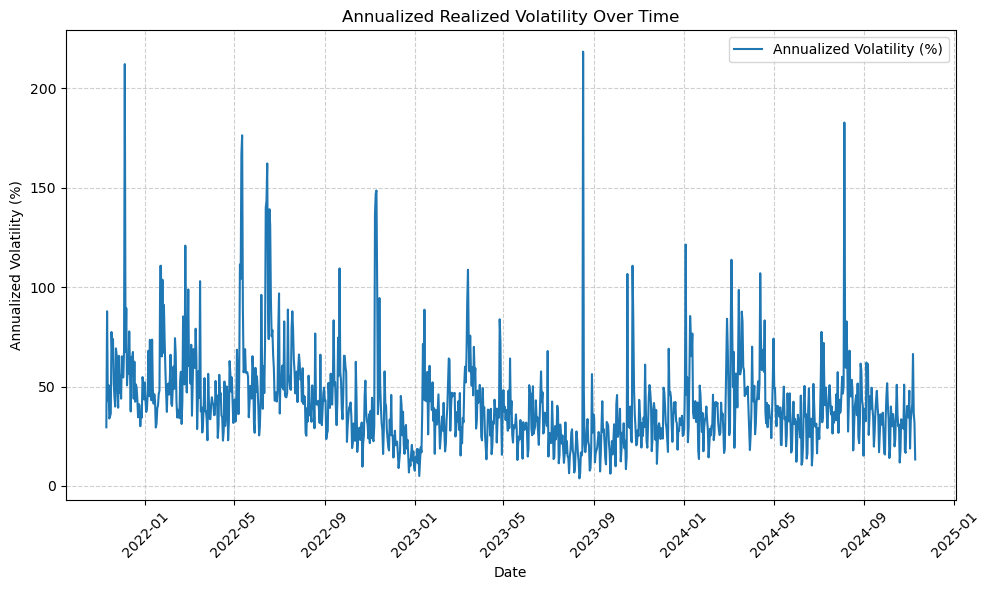

In [4]:
import matplotlib.pyplot as plt
volatility_df['annualized_volatility'] = volatility_df['realized_volatility'] * np.sqrt(365) * 100

# convert to annulized returns
plt.figure(figsize=(10, 6))
plt.plot(volatility_df['date'], volatility_df['annualized_volatility'], label='Annualized Volatility (%)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.title('Annualized Realized Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

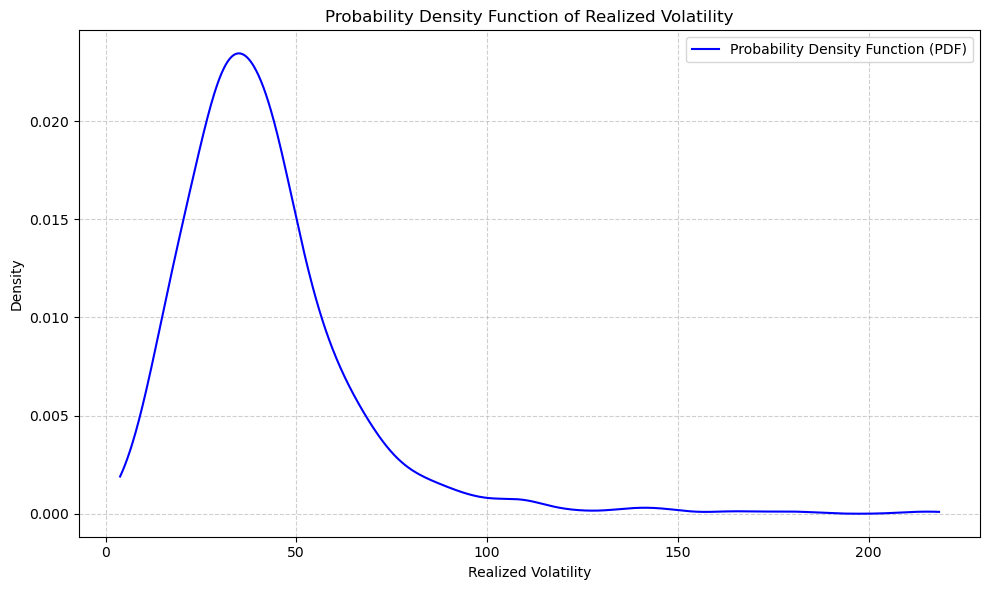

In [5]:
from scipy.stats import gaussian_kde
# Calculate the probability density function (PDF) using Kernel Density Estimation (KDE)
realized_volatility = volatility_df['annualized_volatility']
kde = gaussian_kde(realized_volatility)
x_values = np.linspace(realized_volatility.min(), realized_volatility.max(), 1000)
pdf_values = kde(x_values)

# Plot the probability density function (PDF)
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='Probability Density Function (PDF)', color='blue')
plt.xlabel('Realized Volatility')
plt.ylabel('Density')
plt.title('Probability Density Function of Realized Volatility')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Calculate descriptive statistics
descriptive_stats = {
    'Minimum': realized_volatility.min(),
    'Maximum': realized_volatility.max(),
    'Median': realized_volatility.median(),
    '25th Percentile': realized_volatility.quantile(0.25),
    '75th Percentile': realized_volatility.quantile(0.75),
    'Kurtosis': realized_volatility.kurtosis(),
    'Skewness': realized_volatility.skew()
}

# Display the descriptive statistics
descriptive_stats_df = pd.DataFrame(descriptive_stats, index=[0])

# Display the DataFrame containing the descriptive statistics
from IPython.display import display
display(descriptive_stats_df)

,Minimum,Maximum,Median,25th Percentile,75th Percentile,Kurtosis,Skewness
0,3.811458,218.481623,37.524633,27.805857,49.672797,10.8422,2.416545


## Parkinson Volatility


### **Definition**
Parkinson Realized Volatility (RV) is a method to estimate the volatility of an asset using only its high and low prices for each trading day. It is more efficient than using closing prices alone and is less sensitive to jumps at the market open or close.

---

### **Formula for Parkinson Realized Volatility**

The Parkinson realized volatility for a given day \( t \) is calculated as:

$$
RV_t = \sqrt{\frac{1}{4 \ln(2)} \left( \ln \left( \frac{H_t}{L_t} \right) \right)^2}
$$

Where:
- $RV_t$ = Parkinson realized volatility for day $t$
- $H_t$ = High price of the asset on day $t$
- $L_t$ = Low price of the asset on day $t$
- $\ln$ = Natural logarithm

If there are multiple high/low price intervals per day, the formula generalizes to:

$$
RV_t = \sqrt{\frac{1}{4n \ln(2)} \sum_{i=1}^n \left( \ln \left( \frac{H_{t,i}}{L_{t,i}} \right) \right)^2}
$$

Where:
- $n$ = Total number of high/low price intervals on day $t$
- $H_{t,i}$ = High price of the $i$-th interval on day $t$
- $L_{t,i}$ = Low price of the $i$-th interval on day $t$

---

In [7]:
def calculate_parkinson_rv(price_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parkinson Realized Volatility (RV) for each day using high-frequency intraday data.

    Parameters:
    price_df (pd.DataFrame): A DataFrame containing 'date', 'high', and 'low' columns for each intraday interval.
    
    Returns:
    pd.DataFrame: A DataFrame with the calculated daily Parkinson Realized Volatility (RV) and Annualized Volatility (AV).
    """
    if 'high' not in price_df.columns or 'low' not in price_df.columns or 'date_time' not in price_df.columns:
        raise ValueError("DataFrame must contain 'date_time', 'high', and 'low' columns for price data.")
    
    # Ensure 'date_time' is in datetime format
    price_df['date_time'] = pd.to_datetime(price_df['date_time'], errors='coerce')
    if price_df['date_time'].isnull().any():
        raise ValueError("The 'date_time' column contains invalid datetime values. Please check for NaT or invalid timestamps.")
    
    # Extract the date (YYYY-MM-DD) from the date_time column
    price_df['date'] = price_df['date_time'].dt.date
    
    # Calculate log ratio of high to low prices for each intraday interval
    price_df['log_ratio'] = np.log(price_df['high'] / price_df['low'])
    
    # Calculate the Parkinson daily realized volatility for each day
    daily_parkinson_rv = price_df.groupby('date')['log_ratio'].apply(lambda x: np.sqrt((1 / (4 * np.log(2))) * np.sum(x ** 2)))
    
    # Reset the index and rename the columns
    parkinson_rv_df = daily_parkinson_rv.reset_index()
    parkinson_rv_df.columns = ['date', 'parkinson_rv']
    
    # Calculate the annualized volatility, assuming 252 trading days in a year
    parkinson_rv_df['annualized_volatility'] = parkinson_rv_df['parkinson_rv'] * np.sqrt(252)*100
    
    return parkinson_rv_df

In [8]:
# Read the local price_df_5min.csv file
price_df = pd.read_csv('price_df_5min_.csv')
# Calculate the daily realized parkinson volatility
parkinson_volatility_df = calculate_parkinson_rv(price_df)
# Save the daily realized volatility as a CSV file
parkinson_volatility_df.to_csv('daily_realized_parkinson_volatility.csv', index=False)

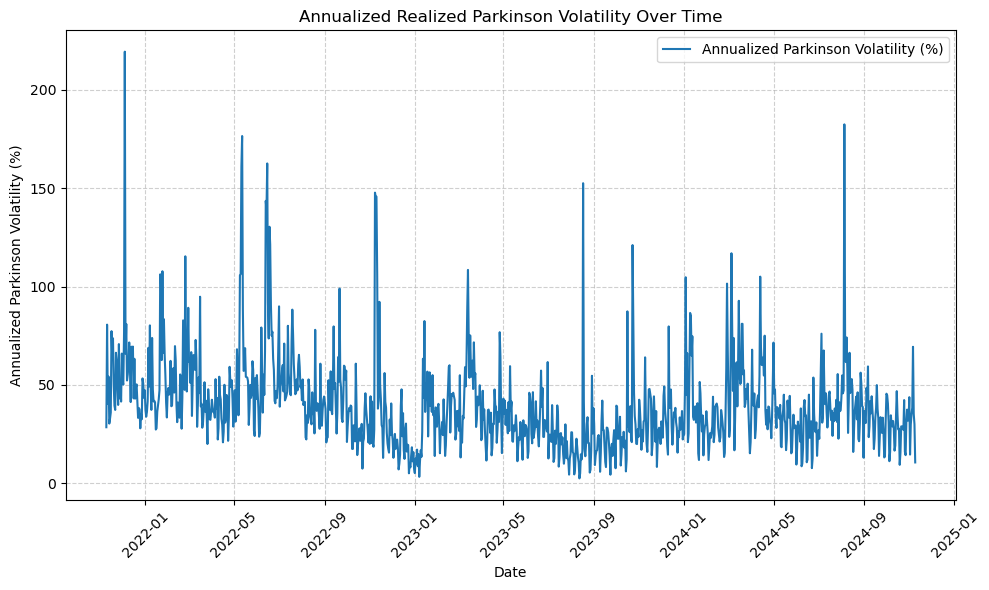

In [9]:
# make plots
plt.figure(figsize=(10, 6))
plt.plot(parkinson_volatility_df['date'], parkinson_volatility_df['annualized_volatility'], label='Annualized Parkinson Volatility (%)')
plt.xlabel('Date')
plt.ylabel('Annualized Parkinson Volatility (%)')
plt.title('Annualized Realized Parkinson Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

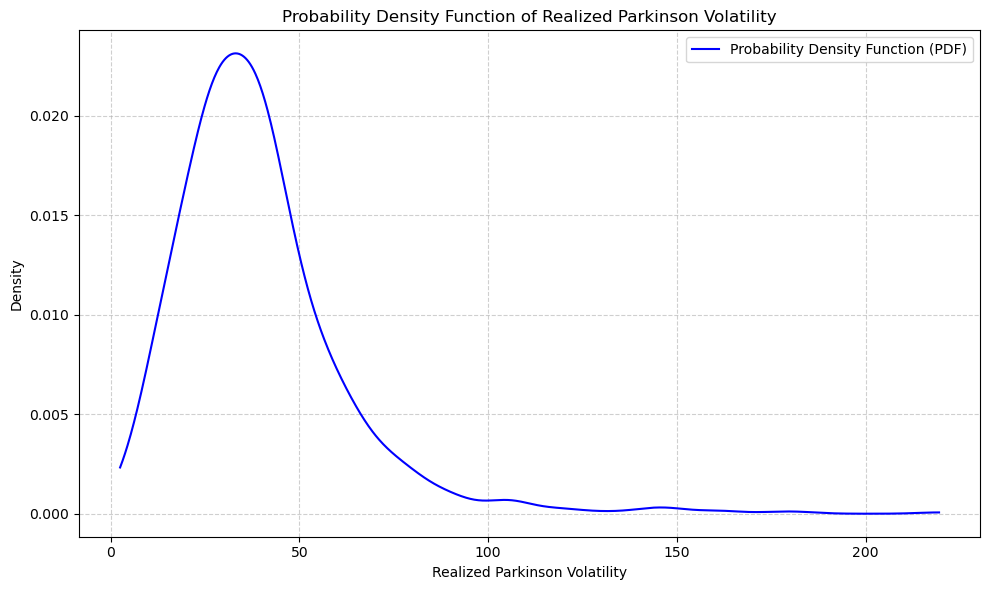

In [10]:
# Calculate the probability density function (PDF) using Kernel Density Estimation (KDE)
realized_volatility = parkinson_volatility_df['annualized_volatility']
kde = gaussian_kde(realized_volatility)
x_values = np.linspace(realized_volatility.min(), realized_volatility.max(), 1000)
pdf_values = kde(x_values)

# Plot the probability density function (PDF)
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='Probability Density Function (PDF)', color='blue')
plt.xlabel('Realized Parkinson Volatility')
plt.ylabel('Density')
plt.title('Probability Density Function of Realized Parkinson Volatility')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Calculate descriptive statistics
descriptive_stats = {
    'Minimum': realized_volatility.min(),
    'Maximum': realized_volatility.max(),
    'Median': realized_volatility.median(),
    '25th Percentile': realized_volatility.quantile(0.25),
    '75th Percentile': realized_volatility.quantile(0.75),
    'Kurtosis': realized_volatility.kurtosis(),
    'Skewness': realized_volatility.skew()
}

# Display the descriptive statistics
descriptive_stats_df = pd.DataFrame(descriptive_stats, index=[0])

# Display the DataFrame containing the descriptive statistics
from IPython.display import display
display(descriptive_stats_df)

,Minimum,Maximum,Median,25th Percentile,75th Percentile,Kurtosis,Skewness
0,2.467483,219.486673,35.912565,25.419513,47.321244,9.721927,2.278131
